In [2]:
import open3d
import numpy as np
import pandas as pd
import os
import tqdm
import copy
import glob
import matplotlib.pyplot as plt

from scipy.signal import argrelmin, argrelmax, find_peaks
from scipy.spatial.transform import Rotation as R
from PIL import Image
from utils.depth_camera import DepthCamera

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
sequence_dirs = glob.glob("data/raw_data/exp_9/trial_*/secondary/subject-*/*/frames")

In [3]:
min_std = 0.5
threshold = 0.5
target_fps = 20

In [4]:
sequence_data = []

for sequence_dir in tqdm.tqdm(sequence_dirs):
    sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
    
    sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)

    mean_values = []
    std_values = []

    for t in range(len(sequence_ts)):
        depth_img = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")).convert("I")
        depth_img = np.array(depth_img) / 4000
        
        mean_values.append(np.mean(depth_img))
        std_values.append(np.std(depth_img))
        
    mean_values = np.array(mean_values)
    std_values = np.array(std_values)
    
    sequence_data.append({
        "sequnce_dir": sequence_dir,
        "num_frames": len(sequence_ts),
        "mean_distances": mean_values,
        "std_distances": std_values
    })

100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


In [5]:
for seq_obj in sequence_data:
    sequence_ts = fread.get_timstamps_from_images(seq_obj["sequnce_dir"], ext=".depth.png")
    sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)
    
    sequence_path = os.path.normpath(seq_obj["sequnce_dir"]).split(os.sep)
    exp, trial, subject, sequence = sequence_path[-6], sequence_path[-5], sequence_path[-3], sequence_path[-2]
    file_name = f"{trial}_{subject}_{sequence}.jpeg"
    
    if not os.path.exists(f"results/plots/std_distances/{exp}"): 
        os.makedirs(f"results/plots/std_distances/{exp}")
        
    if not os.path.exists(f"results/plots/candidates/{exp}"): 
        os.makedirs(f"results/plots/candidates/{exp}")

    std_values = seq_obj["std_distances"]
    max_indices = argrelmax(std_values, order=target_fps)[0]
    
    min_indices = argrelmin(std_values, order=target_fps // 2)[0]
    # min_indices = min_indices[np.where(np.abs(std_values[min_indices] - min_std) < threshold)[0]]
    # min_indices = min_indices[np.where(std_values[min_indices] - min_std < 0)[0]]

    # global_pos = find_candidate_global_pos(std_values, delta=0.2)
    
    # plt.figure(figsize=(20, 20))
    # for i in range(4):
    #     for j in range(4):
    #         img = Image.open(os.path.join(seq_obj["sequnce_dir"], f"frame-{sequence_ts[global_pos[4 * i + j]]}.depth.png")).convert("I")
    #         plt.subplot(4, 4, (4 * i) + j + 1)
    #         plt.imshow(np.asarray(img), cmap="jet")
    #         plt.axis("off")
    
    plt.figure(figsize=(20, 20))
    for i in range(4):
        for j in range(4):
            if 4 * i + j > len(min_indices) - 1:
                break
            
            img = Image.open(os.path.join(seq_obj["sequnce_dir"], f"frame-{sequence_ts[min_indices[4 * i + j]]}.depth.png")).convert("I")
            plt.subplot(4, 4, (4 * i) + j + 1)
            plt.imshow(np.asarray(img), cmap="jet")
            plt.axis("off")
            
    plt.savefig(f"results/plots/candidates/{exp}/{file_name}")        
    plt.close()
            

    plt.figure(figsize=(20, 6))
    plt.plot(std_values)
    
    # plt.scatter(global_pos, std_values[global_pos], c="r", marker="+")
    plt.scatter(min_indices, std_values[min_indices], c="b", marker="x")
    
    for x in min_indices:
        plt.axvline(x, c="b", linestyle="--")
    
    plt.axhline(y=0.5, color="r", linestyle="--")
    plt.ylim(0, 4)
    plt.xlim(0, len(std_values))
    
    plt.xlabel("Frame #")
    plt.ylabel("Std. of Distances to the camera")
    plt.savefig(f"results/plots/std_distances/{exp}/{file_name}")
    plt.close()

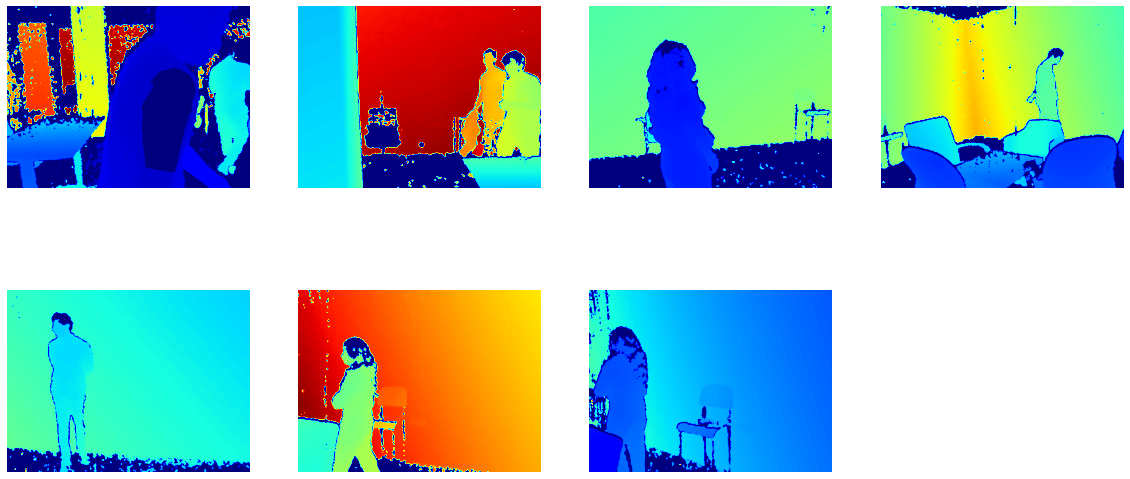

In [45]:
for seq_obj in sequence_data:
    sequence_path = os.path.normpath(seq_obj["sequnce_dir"]).split(os.sep)
    exp, trial, subject, sequence = sequence_path[-6], sequence_path[-5], sequence_path[-3], sequence_path[-2]
    file_name = f"{trial}_{subject}_{sequence}.jpeg"
    
    if not os.path.exists(f"results/plots/mean_distances/{exp}"): 
        os.makedirs(f"results/plots/mean_distances/{exp}")

    std_values = seq_obj["mean_distances"]

    plt.figure(figsize=(20, 6))
    plt.plot(std_values)
    plt.ylim(0, 4)
    plt.savefig(f"results/plots/mean_distances/{exp}/{file_name}")
    plt.close()

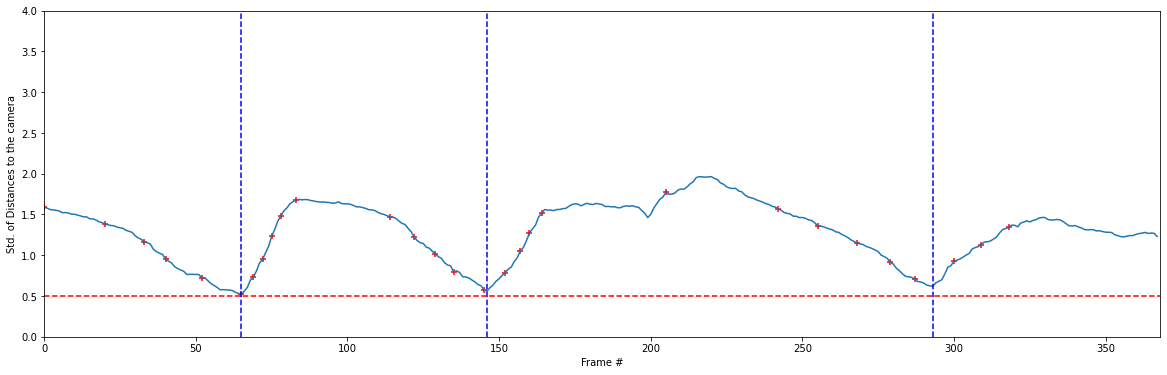

In [61]:
sequence_dir = "data/raw_data/exp_5/trial_1/secondary/subject-1/01/frames"

sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)

mean_values = []
std_values = []

for t in range(len(sequence_ts)):
    depth_img = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

cutoffs = find_cutoffs(std_values, target_fps, min_std, threshold)

global_pos = find_candidate_global_pos(std_values, delta=0.2)

plt.figure(figsize=(20, 6))
plt.plot(std_values)

plt.scatter(global_pos, std_values[global_pos], c="r", marker="+")

for x in cutoffs:
    plt.axvline(x, c="b", linestyle="--")

plt.axhline(y=0.5, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [2]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [10]:
experiment = "exp_5"
dataset_dir = "data/raw_data"
target_fps = 20

for trial in os.listdir(os.path.join(dataset_dir, experiment)):
    if not trial.startswith("trial"): continue
    
    for subject in os.listdir(os.path.join(dataset_dir, experiment, trial, "secondary")):
        for sequence in os.listdir(os.path.join(dataset_dir, experiment, trial, "secondary", subject)):
            sequence_dir = f"{dataset_dir}/{experiment}/{trial}/secondary/{subject}/{sequence}/frames"

            sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
            sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)
            num_frames = len(sequence_ts)
            
            device_0_ts = fread.get_timstamps_from_images(f"{dataset_dir}/{experiment}/{trial}/global/device-0", ext=".depth.png")
            device_1_ts = fread.get_timstamps_from_images(f"{dataset_dir}/{experiment}/{trial}/global/device-1", ext=".depth.png")
            device_2_ts = fread.get_timstamps_from_images(f"{dataset_dir}/{experiment}/{trial}/global/device-2", ext=".depth.png")

            y = [[], [], []]
            x = []

            for i in range(num_frames):
                y[0].append(nearest(device_0_ts, sequence_ts[i]))
                y[1].append(nearest(device_1_ts, sequence_ts[i]))
                y[2].append(nearest(device_2_ts, sequence_ts[i]))
                
                y[0][i] = np.abs(y[0][i] - sequence_ts[i]) * 1e-6
                y[1][i] = np.abs(y[1][i] - sequence_ts[i]) * 1e-6
                y[2][i] = np.abs(y[2][i] - sequence_ts[i]) * 1e-6
                
                x.append(i)
                
            # plt.figure(figsize=(20, 10))    
            # plt.plot(x, y[0], label="device-0")
            # plt.plot(x, y[1], label="device-1")
            # plt.plot(x, y[2], label="device-2")
            # plt.axhline(y=0, color="black", linestyle="--")
            # plt.legend()

            # plt.savefig(f"results/plots/frames_delay/{experiment}__{trial}__{subject}__{sequence}.jpeg")
            # plt.close()
            
            global_frame_delays = np.array(y)
            global_frame_delays_inds = np.ones(global_frame_delays.shape, dtype=np.int8)

            for r, c in np.argwhere(global_frame_delays > 100):
                global_frame_delays_inds[r, c] = 0
                
            global_frame_delays_inds = np.sum(global_frame_delays_inds, axis=0)
            global_frame_delays_inds = np.where(global_frame_delays_inds == 3, 1, 0)
            
            cuttoff_inds = np.array([
                np.squeeze(np.argwhere(np.convolve(global_frame_delays_inds, [-1, 1], mode="same") == -1)), 
                np.squeeze(np.argwhere(np.convolve(global_frame_delays_inds, [-1, 1], mode="same") == 1))
            ], dtype=np.object)
            
            plt.figure(figsize=(20, 10))    
            plt.plot(x, global_frame_delays_inds)
            plt.savefig(f"results/plots/frames_delay/{experiment}__{trial}__{subject}__{sequence}.jpeg")
            plt.close()


In [ ]:
sequence_dir = f"data/raw_data/{experiment}/{trial}/secondary/{subject}/{sequence}/frames"

sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)
num_frames = len(sequence_ts)

device_0_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-0"), ext=".depth.png")
device_1_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-1"), ext=".depth.png")
device_2_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-2"), ext=".depth.png")

y = [[], [], []]
x = []

for i in range(num_frames):
    y[0].append(nearest(device_0_ts, sequence_ts[i]))
    y[1].append(nearest(device_1_ts, sequence_ts[i]))
    y[2].append(nearest(device_2_ts, sequence_ts[i]))
    
    y[0][i] = (y[0][i] - sequence_ts[i]) * 1e-6
    y[1][i] = (y[1][i] - sequence_ts[i]) * 1e-6
    y[2][i] = (y[2][i] - sequence_ts[i]) * 1e-6
    
    x.append(i)
    
    # if i == 100: break
    
plt.figure(figsize=(20, 10))    
plt.plot(x, y[0], label="device-0")
plt.plot(x, y[1], label="device-1")
plt.plot(x, y[2], label="device-2")
plt.axhline(y=0, color="black", linestyle="--")

plt.legend()


Statistical Outlier Removal

In [17]:
def remove_outliers(point_cloud):
    _, ind = point_cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)
    return point_cloud.select_by_index(ind)

In [18]:
feature_file = "data/features/exp_10/trial_1/0.03/subject-1/01/1675753304615.secondary.npz"

pcd = FCGF.get_features(feature_file, pcd_only=True)

inlier_cloud = remove_outliers(pcd)

In [15]:
open3d.visualization.draw_geometries([inlier_cloud])

In [16]:
open3d.visualization.draw_geometries([pcd])